# Megaline Telecom - Tarifas 

# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

1. El proposito del proyecto de la compañía es asegurar mediante el analisis de 5 dataframes cual es el plan de prepago que genera más ingresos en una muestra de 500 usuarios, incluyendo algunos costos extra que se generan a partir de consumir por encima del límite de mensajes, gb en navegación y duración de llamadas de los dos planes a analizar. En primera instancia se debe de estructurar la información por id de usuario y por el mes ya que el cobro del prepago se hace en mensualidad y en este caso se toman en cuenta todos los meses del año 2018. Gracias a una serie de merges podemos conocer el nombre del usuario que realizó cierto número de llamadas, de gb utilizados y por último de mensajes que envió para determinar si paga el monto mensual determinad o si se le suma un costo extra. Al ser un plan básico y uno de lujo, resulta lógico predecir que el plan de lujo en muy pocas ocasiones el usuario vaya a consumir más de lo que permite. De cada data frame se puede obtener variables estadísticas, se pueden hacer gráficos que demuestren el consumo por parte de los usuarios que adquieren estos dos planes. A primera instancia, sería limpiar los datos, hacer un dataframe único que contenga lo mas importante de los dataframes y que nos permita conocer todo en una sola tabla. Ya con eso, manipularla agrupandola u obteniendo columnas en específico para poder graficar de manera clara el comportamiento de los datos. Ese sería el paso medio. Por último y más importante para este sprint sería evaluar mediante una prueba t student si la hipotesis nula es aceptada o es rechazada segun los valores calculados.


## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames
plans_df= pd.read_csv('/datasets/megaline_plans.csv')
users_df= pd.read_csv('/datasets/megaline_users.csv')
calls_df= pd.read_csv('/datasets/megaline_calls.csv')
messages_df = pd.read_csv('/datasets/megaline_messages.csv')
internet_df= pd.read_csv('/datasets/megaline_internet.csv')

## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans_df.info(show_counts=True)
plans_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
std,671.751442,10861.160159,1767.766953,35.355339,2.12132,0.014142,0.014142
min,50.000000,15360.000000,500.000000,20.000000,7.00000,0.010000,0.010000
25%,287.500000,19200.000000,1125.000000,32.500000,7.75000,0.015000,0.015000
50%,525.000000,23040.000000,1750.000000,45.000000,8.50000,0.020000,0.020000
75%,762.500000,26880.000000,2375.000000,57.500000,9.25000,0.025000,0.025000
max,1000.000000,30720.000000,3000.000000,70.000000,10.00000,0.030000,0.030000


In [4]:
#Valores duplicados en plans
plans_df_dp= plans_df.duplicated().sum()
print('Valores duplicados: ',plans_df_dp)
print('\n')
#Valores ausentes en plans
plans_df_au= plans_df.isna().sum()
print('Valores ausentes en alguna columna:', plans_df_au)
print('\n')
# Imprime una muestra de los datos para las tarifas
#Son solo dos columnas, por lo que se imprime completo y no con .sample()
display(plans_df)

Valores duplicados:  0


Valores ausentes en alguna columna: messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64




,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Se aprecia bien lo que viene incluido en cada plan expresado en dolares y las tarifas de costo extra por cada gb (1000 mb), por cada mensaje fuera de los incluidos por mes y de los minutos. Queda claro que la tarifa mensual es fija para cada usuario y dependiendo de su actividad en el mes son los cargos extras que resultaran en una cuenta total a pagar. Los mb deberían ser sustituidos por el valor en gb.

Es la información general de los planes que ofrece la compañía telefónica. Son los mensajes, los mb de navegación, los minutos y los precios incluidos de ambos paquetes.  Claro, junto con los nombres.

## Corregir datos

[Corregir los problemas obvios con los datos basándote en las observaciones iniciales.]

In [5]:
plans_df['gb_per_month_included']=plans_df['mb_per_month_included']/1024
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


## Enriquecer los datos

## Usuarios/as

In [6]:
users_df.describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


In [7]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
users_df.info(show_counts=True)
users_df.describe()
print('\n')

#Valores ausentes en users
users_df_date_au= users_df['churn_date'].isnull().sum()
print(f'Número de datos ausentes de la columna "churn_date": {users_df_date_au}')
print('\n')

#Duplicados en users
users_df_au=users_df.duplicated().sum()
print(f'Número de datos duplicados en users :{users_df_au}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Número de datos ausentes de la columna "churn_date": 466


Número de datos duplicados en users :0


In [8]:
# Imprime una muestra de datos para usuarios
display(users_df.sample(8))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16
479,1479,Keesha,Burnett,44,"Riverside-San Bernardino-Ontario, CA MSA",2018-11-12,surf,NaN
90,1090,Brock,Skinner,30,"Indianapolis-Carmel-Anderson, IN MSA",2018-05-12,surf,NaN
84,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11
335,1335,Gail,Coleman,61,"Dallas-Fort Worth-Arlington, TX MSA",2018-06-02,surf,NaN
157,1157,Luciano,Sheppard,63,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-07-02,surf,NaN
11,1011,Halina,Henry,73,"Cleveland-Elyria, OH MSA",2018-01-18,ultimate,NaN
199,1199,Antonetta,Finley,39,"San Antonio-New Braunfels, TX MSA",2018-08-01,ultimate,NaN


En la tabla con valores al azar se distingue que se encuentra la descripción del usuario junto con el lugar donde habita y una especie e abreviación dentro de esa columna. De igual forma la columna de reg_date habría que checar que esté como una variable de fecha para su estructuración en futuras ramas de este data frame y que no se quede como un string. Las abreviaciones se buscara separarlas en otra columna.

### Corregir los datos

Tengo la duda con que valor o fecha se deben de tomar los NaT en churn date, si se dejan así o como la ultima fecha registrada que es el 31/12/2018. Porque de ser la primera opción, se pueden quedar como 'been used' o en uso, se tomaría como string.
(si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos). Por eso hago esta nota

In [9]:
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'],format='%Y-%m-%d',errors='coerce')
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'],format='%Y-%m-%d')
display(users_df.head(10))
# users_df['churn_date']=users_df['churn_date'].fillna(value='31-12-2018')
# display(users_df.head(10))


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaT
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaT


### Enriquecer los datos

Aquí se hace la separación city y state

In [10]:
users_df[['city','state']]=users_df['city'].str.split(',',expand=True)
display(users_df.sample(10))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,state
216,1216,Reita,Atkins,29,San Francisco-Oakland-Berkeley,2018-06-19,surf,NaT,CA MSA
381,1381,German,Burris,44,Austin-Round Rock-Georgetown,2018-08-30,surf,NaT,TX MSA
297,1297,Nicky,Tucker,51,Los Angeles-Long Beach-Anaheim,2018-08-25,surf,NaT,CA MSA
278,1278,Masako,Montgomery,39,Dayton-Kettering,2018-11-03,surf,NaT,OH MSA
198,1198,Russ,Horne,69,New York-Newark-Jersey City,2018-05-01,surf,NaT,NY-NJ-PA MSA
421,1421,Zane,Hobbs,26,Phoenix-Mesa-Chandler,2018-05-18,surf,NaT,AZ MSA
267,1267,Gia,Parker,53,St. Louis,2018-03-12,surf,NaT,MO-IL MSA
39,1039,Flo,Hicks,56,Columbus,2018-05-30,ultimate,NaT,OH MSA
455,1455,Jude,Fischer,20,Denver-Aurora-Lakewood,2018-08-13,surf,NaT,CO MSA
324,1324,Romana,Moore,18,Minneapolis-St. Paul-Bloomington,2018-04-04,surf,NaT,MN-WI MSA


## Llamadas

In [11]:
display(users_df)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,state
0,1000,Anamaria,Bauer,45,Atlanta-Sandy Springs-Roswell,2018-12-24,ultimate,NaT,GA MSA
1,1001,Mickey,Wilkerson,28,Seattle-Tacoma-Bellevue,2018-08-13,surf,NaT,WA MSA
2,1002,Carlee,Hoffman,36,Las Vegas-Henderson-Paradise,2018-10-21,surf,NaT,NV MSA
3,1003,Reynaldo,Jenkins,52,Tulsa,2018-01-28,surf,NaT,OK MSA
4,1004,Leonila,Thompson,40,Seattle-Tacoma-Bellevue,2018-05-23,surf,NaT,WA MSA
...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,New York-Newark-Jersey City,2018-09-04,surf,NaT,NY-NJ-PA MSA
496,1496,Ariel,Shepherd,49,New Orleans-Metairie,2018-02-20,surf,NaT,LA MSA
497,1497,Donte,Barrera,49,Los Angeles-Long Beach-Anaheim,2018-12-10,ultimate,NaT,CA MSA
498,1498,Scot,Williamson,51,New York-Newark-Jersey City,2018-02-04,surf,NaT,NY-NJ-PA MSA


In [12]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls_df.info(show_counts=True)
calls_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [60]:
# Redondear hacia arriba aunque el entero tenga una decima
calls_df['duration']=np.ceil(calls_df['duration'])
# display('Valor máximo de llamadas en minutos: ',calls_df['duration'].max())
calls_df['id']=calls_df['id'].str.replace('_','-')
display(calls_df)

,id,user_id,call_date,duration
0,1000-93,1000,2018-12-27,9.0
1,1000-145,1000,2018-12-27,14.0
2,1000-247,1000,2018-12-27,15.0
3,1000-309,1000,2018-12-28,6.0
4,1000-380,1000,2018-12-30,5.0
...,...,...,...,...
137730,1499-199,1499,2018-11-21,9.0
137731,1499-200,1499,2018-10-20,11.0
137732,1499-201,1499,2018-09-21,9.0
137733,1499-202,1499,2018-10-10,1.0


Ya se encuentra la columa de call_data a valores de un formato de fecha y no de strings, aún faltaría tener una columna donde se distingan los meses de cada llamada y así se puedan ir contando si se desea hacer una agrupación de datos. Lo demás se ve normal.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [14]:
#Duplicados en calls
calls_df_dp=calls_df.duplicated().sum()
print('Valor de filas duplicadas : ',calls_df_dp)
calls_df['call_date']=pd.to_datetime(calls_df['call_date'],format='%Y-%m-%d',errors='coerce')

Valor de filas duplicadas :  0


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [15]:
# Imprime una muestra de datos para las llamadas
calls_df.head()

,id,user_id,call_date,duration
0,1000-93,1000,2018-12-27,9.0
1,1000-145,1000,2018-12-27,14.0
2,1000-247,1000,2018-12-27,15.0
3,1000-309,1000,2018-12-28,6.0
4,1000-380,1000,2018-12-30,5.0


## Mensajes

In [16]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages_df.info(show_counts=True)
messages_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,user_id
count,76051.000000
mean,1245.972768
std,139.843635
min,1000.000000
25%,1123.000000
50%,1251.000000
75%,1362.000000
max,1497.000000


Decidí que en id de los mensajes en lugar de colocar un guión bajo, poner un guión medio, con la finalidad de diferenciarlos con los de las llamadas y evitar alguna repetición de una combinación que sea la misma para un mensaje que para una llamada en específico. De igual forma la columna message date ya contiene formato de fecha y no de string

### Corregir los datos

In [17]:
messages_df_dp=messages_df.duplicated().sum()
print('Valores duplicados : ',messages_df_dp)
messages_df['message_date']=pd.to_datetime(messages_df['message_date'],format='%Y-%m-%d',errors='coerce')
messages_df['id']=messages_df['id'].str.replace('_','-')

Valores duplicados :  0


### Enriquecer los datos

In [18]:
# Imprime una muestra de datos para los mensajes
messages_df.sample(10)

,id,user_id,message_date
68332,1440-198,1440,2018-08-31
66138,1433-78,1433,2018-11-22
34633,1220-144,1220,2018-06-20
22016,1132-1587,1132,2018-08-10
47219,1320-463,1320,2018-09-09
45772,1312-256,1312,2018-03-23
33726,1212-192,1212,2018-12-30
34666,1220-182,1220,2018-07-10
26807,1164-57,1164,2018-07-17
60627,1382-219,1382,2018-12-02


## Internet

In [19]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet_df.info(show_counts=True)
internet_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


Nuevamente decidí separar los números del id con un caracter diferente para diferenciarlo. Agregué una columna de gb used donde dividí los mb used entre 1000. La session data ya se encuentra en el formato de horario

### Corregir los datos

In [20]:
internet_df['gb_used']=np.ceil(internet_df['mb_used'])/1024
# internet_df['gb_used']=np.ceil(internet_df['gb_used'])
internet_df['session_date']=pd.to_datetime(internet_df['session_date'],format='%Y-%m-%d',errors='coerce')

### Enriquecer los datos

In [21]:
# Imprime una muestra de datos para el tráfico de internet
print('Valores repetidos en internet: ',internet_df.duplicated().sum())
internet_df['id']=internet_df['id'].str.replace('_','/')
internet_df.sample(30)

Valores repetidos en internet:  0


,id,user_id,session_date,mb_used,gb_used
84460,1394/2,1394,2018-12-09,678.47,0.663086
102717,1491/202,1491,2018-06-08,668.56,0.653320
66372,1310/6,1310,2018-12-14,98.05,0.096680
21022,1098/42,1098,2018-09-05,857.58,0.837891
31493,1144/216,1144,2018-06-20,771.82,0.753906
57827,1261/288,1261,2018-12-22,36.59,0.036133
83942,1391/198,1391,2018-11-01,505.18,0.494141
65733,1304/109,1304,2018-11-07,645.78,0.630859
48846,1217/186,1217,2018-11-02,373.10,0.365234
38580,1172/235,1172,2018-12-23,370.70,0.362305


## Estudiar las condiciones de las tarifas

In [22]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
display(plans_df)
calls_df.sample(10)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


,id,user_id,call_date,duration
99456,1357-184,1357,2018-09-07,7.0
114755,1402-1,1402,2018-10-09,12.0
39492,1147-240,1147,2018-09-12,0.0
127950,1459-94,1459,2018-11-10,16.0
123240,1434-594,1434,2018-06-23,6.0
113874,1400-214,1400,2018-04-25,13.0
27254,1103-44,1103,2018-09-30,3.0
127783,1458-80,1458,2018-09-11,0.0
39156,1146-107,1146,2018-12-31,13.0
26894,1101-221,1101,2018-07-19,0.0


## Agregar datos por usuario


In [23]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
calls_df_pr=users_df.merge(calls_df,on='user_id',how='left')
# display(calls_df_pr)
# print(len(calls_df_pr))
# calls_prove=calls_df_pr.groupby('user_id')['duration'].sum()
# display(calls_prove)
pp=calls_df_pr['plan']

calls_df_pr['month']= calls_df['call_date'].dt.to_period('M')
# calls_df_pr['plan']=pp
calls_df_by_user= calls_df_pr.groupby(['user_id','month','plan'])['call_date'].count().reset_index()
 
pp=['user_id','month','plan','calls']
calls_df_by_user.columns=pp
display(calls_df_by_user)
# calls_comp= calls_df[calls_df['user_id']==1000]
# calls_comp= calls_comp['duration round'].sum()
# display(calls_comp)

,user_id,month,plan,calls
0,1000,2018-12,ultimate,16
1,1001,2018-08,surf,27
2,1001,2018-09,surf,49
3,1001,2018-10,surf,65
4,1001,2018-11,surf,64
...,...,...,...,...
2788,1498,2018-12,surf,41
2789,1499,2018-09,surf,39
2790,1499,2018-10,surf,46
2791,1499,2018-11,surf,40


In [24]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
calls_df_min_mon = calls_df_pr.groupby(['user_id','month'])[['duration','plan']].sum().reset_index()
display(calls_df_min_mon)

,user_id,month,duration
0,1000,2018-12,124.0
1,1001,2018-08,182.0
2,1001,2018-09,315.0
3,1001,2018-10,393.0
4,1001,2018-11,426.0
...,...,...,...
2788,1498,2018-12,305.0
2789,1499,2018-09,268.0
2790,1499,2018-10,335.0
2791,1499,2018-11,329.0


In [25]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
messages_df['month']=messages_df['message_date'].dt.to_period('M')
# display(messages_df.sample(10))
messages_mess_mo= messages_df.groupby(['user_id','month'])['id'].count().reset_index()
messages_mess_mo.columns= ['user_id','month','messages']
# messages_df.info()
display(messages_mess_mo)

,user_id,month,messages
0,1000,2018-12,11
1,1001,2018-08,30
2,1001,2018-09,44
3,1001,2018-10,53
4,1001,2018-11,36
...,...,...,...
1801,1496,2018-09,21
1802,1496,2018-10,18
1803,1496,2018-11,13
1804,1496,2018-12,11


In [26]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
internet_df.info()
internet_df['month']=internet_df['session_date'].dt.to_period('M')
internet_gb_mon= internet_df.groupby(['user_id','month'])['gb_used'].sum().reset_index()
display(internet_gb_mon)

# display(internet_df[internet_df['user_id']==1000])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.0+ MB


,user_id,month,gb_used
0,1000,2018-12,1.858398
1,1001,2018-08,6.766602
2,1001,2018-09,13.020508
3,1001,2018-10,21.832031
4,1001,2018-11,18.089844
...,...,...,...
2272,1498,2018-12,22.617188
2273,1499,2018-09,12.699219
2274,1499,2018-10,19.057617
2275,1499,2018-11,16.439453


In [27]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

# display(internet_gb_mon)
# display(messages_mess_mo)
# display(calls_df_by_user)
# display(calls_df_min_mon)

# plan_puser=users_df.groupby(['user_id','plan'])[['user_id','plan']]
# display(plan_puser.head())

calls_min_mess_inter = calls_df_by_user.merge(calls_df_min_mon,on=['user_id','month'],how='left')
calls_min_mess_inter = calls_min_mess_inter.merge(messages_mess_mo,on=['user_id','month'],how='left')
calls_min_mess_inter = calls_min_mess_inter.merge(internet_gb_mon,on=['user_id','month'],how='left')
display(calls_min_mess_inter.groupby('user_id')['messages'].sum())
#Redondeo al final para poder cobrar minutos y navegación extra al mes y que no sea por dia de consumo
calls_min_mess_inter['duration']=np.ceil(calls_min_mess_inter['duration'])
calls_min_mess_inter['gb_used']=np.ceil(calls_min_mess_inter['gb_used'])
# 1 7 14 23 19
display(calls_min_mess_inter)

user_id
1000     11.0
1001    207.0
1002     88.0
1003     50.0
1004    177.0
        ...  
1495      0.0
1496     65.0
1497     50.0
1498      0.0
1499      0.0
Name: messages, Length: 500, dtype: float64

,user_id,month,plan,calls,duration,messages,gb_used
0,1000,2018-12,ultimate,16,124.0,11.0,2.0
1,1001,2018-08,surf,27,182.0,30.0,7.0
2,1001,2018-09,surf,49,315.0,44.0,14.0
3,1001,2018-10,surf,65,393.0,53.0,22.0
4,1001,2018-11,surf,64,426.0,36.0,19.0
...,...,...,...,...,...,...,...
2788,1498,2018-12,surf,41,305.0,NaN,23.0
2789,1499,2018-09,surf,39,268.0,NaN,13.0
2790,1499,2018-10,surf,46,335.0,NaN,20.0
2791,1499,2018-11,surf,40,329.0,NaN,17.0


In [28]:
# Añade la información de la tarifa
total_ultimate=calls_min_mess_inter[calls_min_mess_inter['plan']=='ultimate']
total_surf=calls_min_mess_inter[calls_min_mess_inter['plan']=='surf']
display(total_ultimate.sample())
# display(calls_total_pt2)
display(plans_df)



,user_id,month,plan,calls,duration,messages,gb_used
434,1088,2018-08,ultimate,31,213.0,42.0,19.0


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


INGRESOS MENSUALES

In [29]:
# DATOS DE PAQUETE SURF

In [30]:
#Minutos
total_surf= total_surf.copy() #Se hace la copia para evitar la alerta
total_surf['messages']=total_surf['messages'].fillna(0)
total_surf['gb_used']=total_surf['gb_used'].fillna(0)
#Internet
ex_char_surf=[]
for index,row in total_surf.iterrows():
    if row['duration']>500:
        rest=row['duration']-500
        ex_char_bill=rest*0.03
        ex_char_surf.append(ex_char_bill)
#         print(row)
    else:
        ex_char_bill=0
        ex_char_surf.append(ex_char_bill)

total_surf['charge_duration']=ex_char_surf
# display(total_surf[total_surf['duration']>500].head(10))

#Mensajes
exc_messages=[]
for index, row in total_surf.iterrows():
    if row['messages']>50:
        rest=row['messages']-50
        carg=rest*0.03
        exc_messages.append(carg)
#         print(row)
    else:
        carg=0
        exc_messages.append(carg)
        
total_surf['charge_messages']=exc_messages
display(total_surf.head(10))


,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages
1,1001,2018-08,surf,27,182.0,30.0,7.0,0.00,0.00
2,1001,2018-09,surf,49,315.0,44.0,14.0,0.00,0.00
3,1001,2018-10,surf,65,393.0,53.0,22.0,0.00,0.09
4,1001,2018-11,surf,64,426.0,36.0,19.0,0.00,0.00
5,1001,2018-12,surf,56,412.0,44.0,19.0,0.00,0.00
6,1002,2018-10,surf,11,59.0,15.0,7.0,0.00,0.00
7,1002,2018-11,surf,55,386.0,32.0,19.0,0.00,0.00
8,1002,2018-12,surf,47,384.0,41.0,15.0,0.00,0.00
9,1003,2018-12,surf,149,1104.0,50.0,27.0,18.12,0.00
10,1004,2018-05,surf,21,193.0,7.0,7.0,0.00,0.00


In [31]:
ex_gb=[]
total_surf['gb_used']=total_surf['gb_used'].fillna(0)
for index, row in total_surf.iterrows():
    if row['gb_used']>15:
        rest=row['gb_used']-15
        cost=rest*10
        ex_gb.append(cost)
#         print(row)
    else:
        cost=0
        ex_gb.append(cost)
        
total_surf['charge_internet']=ex_gb
total_surf['monthly_charge']=20
total_surf['total_charge']=total_surf['charge_duration']+total_surf['charge_messages']+total_surf['monthly_charge']+total_surf['charge_internet']
display(total_surf.sample(10))

,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge
1599,1293,2018-11,surf,85,540.0,110.0,30.0,1.20,1.80,150.0,20,173.00
1314,1245,2018-02,surf,2,2.0,0.0,0.0,0.00,0.00,0.0,20,20.00
2465,1439,2018-10,surf,41,340.0,77.0,18.0,0.00,0.81,30.0,20,50.81
511,1103,2018-09,surf,58,473.0,24.0,19.0,0.00,0.00,40.0,20,60.00
2484,1443,2018-12,surf,100,716.0,19.0,27.0,6.48,0.00,120.0,20,146.48
611,1122,2018-12,surf,55,475.0,24.0,21.0,0.00,0.00,60.0,20,80.00
2037,1367,2018-10,surf,23,159.0,0.0,19.0,0.00,0.00,40.0,20,60.00
2640,1471,2018-09,surf,1,16.0,0.0,0.0,0.00,0.00,0.0,20,20.00
1074,1201,2018-09,surf,56,325.0,4.0,25.0,0.00,0.00,100.0,20,120.00
1767,1325,2018-09,surf,3,16.0,0.0,0.0,0.00,0.00,0.0,20,20.00


In [32]:
total_ultimate = total_ultimate.copy()  # Hacer una copia completa
# Calcula el ingreso mensual para cada usuario
total_ultimate['messages']=total_ultimate['messages'].fillna(0)
#Minutos
ex_char_list=[]
for index, row in total_ultimate.iterrows():  # Iterar sobre filas del DataFrame
    if row['duration'] > 3000:  # Comparar duración de cada fila
        print(row)
        mor_min = 3000-row['duration']  # Calcular minutos extras
        ex_char = mor_min * 0.03  # Calcular el cargo extra
        ex_char_list.append(ex_char)
print('las filas de los usuarios que excedieron el limite de 3000 minutos de duración por llamada:',ex_char_list)       
#Mensajes
ex_char_lid=[]

for index, row in total_ultimate.iterrows():
    if row['messages']>1000:
        exex=row
        ex_chat_lid.append(exex)
        print(row)
print('las filas de los usuarios que excedieron el limite de 1000 mensajes:',ex_char_lid)       

ex_char_in_list=[]

# Internet
total_ultimate['gb_used']=total_ultimate['gb_used'].fillna(0)
for index, row in total_ultimate.iterrows():
    if row['gb_used']>30:
        rest=row['gb_used']-30
        ex_char_in=rest*7
        ex_char_in_list.append(ex_char_in)
      
    else:
        ex_char_in=0
        ex_char_in_list.append(ex_char_in)


las filas de los usuarios que excedieron el limite de 3000 minutos de duración por llamada: []
las filas de los usuarios que excedieron el limite de 1000 mensajes: []


Se observa que en la duración máxima de minutos de llamadas del plan ultimate es la siguiente:

In [33]:
display(total_ultimate[total_ultimate['duration']>3000])
print(total_ultimate['duration'].max())

,user_id,month,plan,calls,duration,messages,gb_used


1435.0


Se observa que el valor máximo de mensajes del plan ultimate es la siguiente:

In [34]:
display(total_ultimate[total_ultimate['messages']>1000])
print(total_ultimate['messages'].max())

,user_id,month,plan,calls,duration,messages,gb_used


166.0


In [35]:
total_ultimate['charge_duration']=0
total_ultimate['charge_messages']=0

total_ultimate['charge_internet']=ex_char_in_list
total_ultimate['monthly_charge']=70
total_ultimate['total_charge']=total_ultimate['charge_internet']+total_ultimate['monthly_charge']+total_ultimate['charge_duration']+total_ultimate['charge_messages']
display(total_ultimate[total_ultimate['duration']==1358])


,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge


## Estudia el comportamiento de usuario

[Calcular algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibujar gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]



### Llamadas

In [36]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

total_surf_mean_cou=total_surf.groupby('month')['duration'].count().reset_index()
total_surf_mean_sum=total_surf.groupby('month')['duration'].sum().reset_index()
# print(total_surf_mean_cou)
# print(total_surf_mean_sum)

total_surf_mean_tt=total_surf_mean_cou.merge(total_surf_mean_sum,on='month',how='left')
total_surf_mean_tt.columns=['month','n of calls','duration']
total_surf_mean_tt['average']=total_surf_mean_tt['duration']/total_surf_mean_tt['n of calls']
month_string=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
total_surf_mean_tt['month str']=month_string
display(total_surf_mean_tt)

print('\n')
###Ultimate

total_ult_mean_cou=total_ultimate.groupby('month')['duration'].count().reset_index()
total_ult_mean_sum=total_ultimate.groupby('month')['duration'].sum().reset_index()
# print(total_surf_mean_cou)
# print(total_surf_mean_sum)

total_ult_mean_tt=total_ult_mean_cou.merge(total_ult_mean_sum,on='month',how='left')
total_ult_mean_tt.columns=['month','n of calls','duration']
total_ult_mean_tt['average']=total_ult_mean_tt['duration']/total_ult_mean_tt['n of calls']
total_ult_mean_tt['month str']=month_string
display(total_ult_mean_tt)

# x = np.arange(len(total_surf_mean_tt['month str']))
# plt.bar(x - 0.3/2,total_surf_mean_tt['month str'], total_surf_mean_tt['average'], label='Surf', alpha=0.6)
# plt.bar(x + 0.3/2,total_ult_mean_tt['month str'], total_ult_mean_tt['average'],label='Surf', alpha=0.6)

# ##Posicion de los meses
# x = np.arange(len(total_surf_mean_tt['month str'])) 
# width = 0.2

# # Gráfico Surf
# plt.bar(x - width/2, total_surf_mean_tt['average'], width=width, label='Surf', alpha=0.6)

# # Gráfico Ultimate
# plt.bar(x + width/2, total_ult_mean_tt['average'], width=width, label='Ultimate', alpha=0.6)
# plt.xlim(-0.5,11.5)

# plt.show()

,month,n of calls,duration,average,month str
0,2018-01,4,484.0,121.000000,Jan
1,2018-02,12,2475.0,206.250000,Feb
2,2018-03,32,7489.0,234.031250,Mar
3,2018-04,69,17788.0,257.797101,Apr
4,2018-05,98,30690.0,313.163265,May
5,2018-06,137,41227.0,300.927007,Jun
6,2018-07,167,54079.0,323.826347,Jul
7,2018-08,213,65801.0,308.924883,Aug
8,2018-09,242,80970.0,334.586777,Sept
9,2018-10,283,103733.0,366.547703,Oct


,month,n of calls,duration,average,month str
0,2018-01,4,809.0,202.250000,Jan
1,2018-02,10,2847.0,284.700000,Feb
2,2018-03,17,3941.0,231.823529,Mar
3,2018-04,31,7188.0,231.870968,Apr
4,2018-05,51,11590.0,227.254902,May
5,2018-06,66,17695.0,268.106061,Jun
6,2018-07,84,24174.0,287.785714,Jul
7,2018-08,103,29842.0,289.728155,Aug
8,2018-09,119,36704.0,308.436975,Sept
9,2018-10,126,47835.0,379.642857,Oct


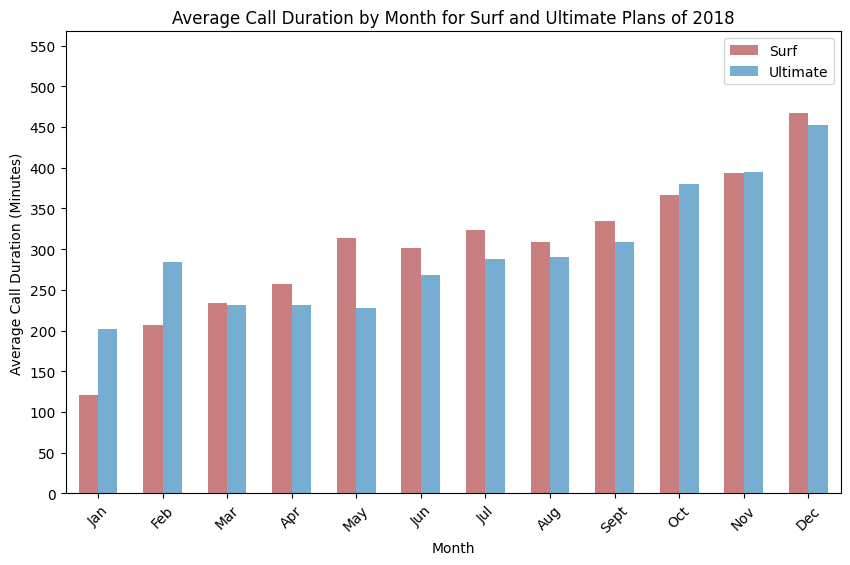

<Figure size 1000x600 with 0 Axes>

In [37]:
# Posiciones para las barras
x = np.arange(len(total_surf_mean_tt['month str']))  # Posiciones de los meses
width = 0.3
plt.figure(figsize=(10,6))
# Gráfic urf
plt.bar(x - width/2, total_surf_mean_tt['average'], width=width, label='Surf', alpha=0.6, color='brown')

# Gráfico ltimate
plt.bar(x + width/2, total_ult_mean_tt['average'], width=width, label='Ultimate', alpha=0.6)

# Establecer las etiquetas del eje X con los nombres de los meses
plt.xticks(x, total_surf_mean_tt['month str'], rotation=45)  # Ajustar las etiquetas del eje X
plt.yticks(np.arange(0, max(total_surf_mean_tt['average']) + 100, 50))

plt.xlim(-0.5, len(total_surf_mean_tt['month str']) - 0.5) 
plt.ylim(0,total_surf_mean_tt['average'].max()+100)


plt.xlabel('Month')  
plt.ylabel('Average Call Duration (Minutes)') 
plt.title('Average Call Duration by Month for Surf and Ultimate Plans of 2018') 
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

El plan de surf tiene mayor número de promedio de minutos en las llamadas durante todo el año Los meses de Marzo a Septiembre y el mes de Diciembre se aprecia en la gráfica que sus valores son mayores a los del pna de Ultimate, siendo 8 meses en los que tiene prevalencia. Mientras que los de ultimate son mayores en los meses de Enero, febrero, Octubre y Noviembre. Resalta que conforme avanzan los meses los valores de ambos planes van en aumento hasta llegar a un número de promedio de minutos máximos en Diciembre

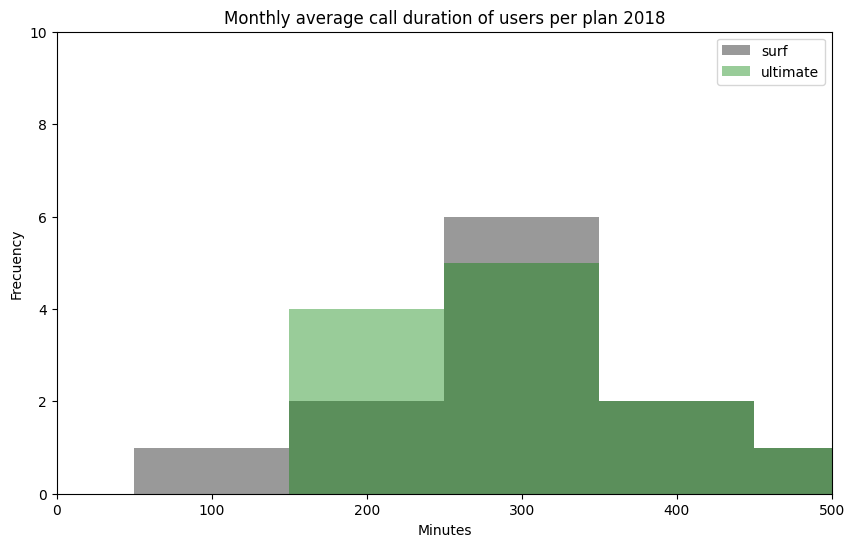

,user_id,month,plan,duration
0,1000,2018-12,ultimate,124.0
1,1001,2018-08,surf,182.0
2,1001,2018-09,surf,315.0
3,1001,2018-10,surf,393.0
4,1001,2018-11,surf,426.0
...,...,...,...,...
2788,1498,2018-12,surf,305.0
2789,1499,2018-09,surf,268.0
2790,1499,2018-10,surf,335.0
2791,1499,2018-11,surf,329.0


In [38]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# Gráfic urf
plt.figure(figsize=(10,6))
plt.hist(total_surf_mean_tt['average'], bins=[50,150, 250, 350, 450,550], alpha=0.8, color='grey',label='surf')
plt.hist(total_ult_mean_tt['average'], bins=[50,150, 250, 350, 450,550],alpha=0.4, color='green',label='ultimate')
plt.xlim(0,500,50)
plt.ylim(0,10,1)
plt.legend()
plt.title('Monthly average call duration of users per plan 2018')
plt.ylabel('Frecuency')
plt.xlabel('Minutes')
plt.show()

#Agrupar numero de minutos por usuario al mes
ag_user_min_mon= calls_min_mess_inter.groupby(['user_id','month','plan'])['duration'].sum().reset_index()
display(ag_user_min_mon)

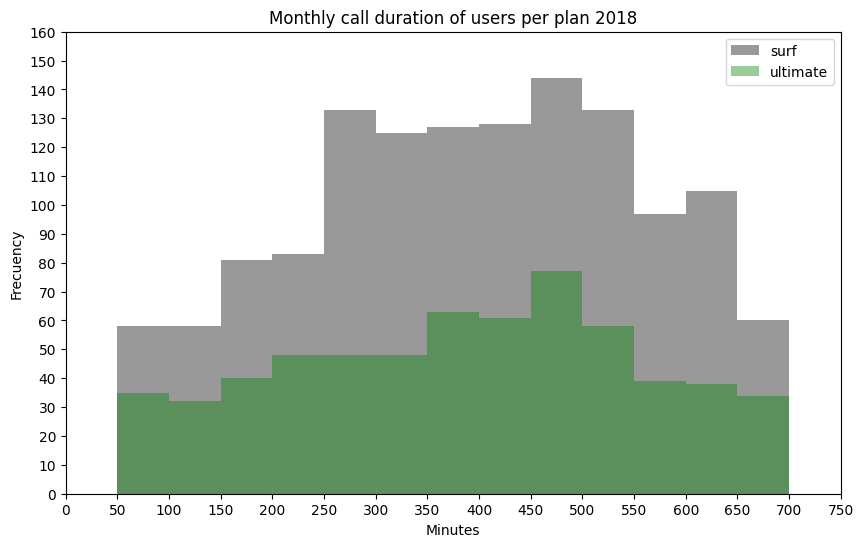

In [39]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
# Gráfic urf
plt.figure(figsize=(10,6))
plt.hist(total_surf['duration'], bins=[50,100, 150, 200, 250,300,350,400,450, 500, 550, 600, 650, 700], alpha=0.8, color='grey',label='surf')
plt.hist(total_ultimate['duration'], bins=[50,100, 150, 200, 250,300,350,400,450, 500, 550, 600, 650, 700],alpha=0.4, color='green',label='ultimate')
plt.xticks(range(0, 751, 50))  
plt.yticks(range(0, 170, 10))   

plt.legend()
plt.title('Monthly call duration of users per plan 2018')
plt.ylabel('Frecuency')
plt.xlabel('Minutes')
plt.show()

#Agrupar numero de minutos por usuario al mes
# ag_user_min_mon= calls_min_mess_inter.groupby(['user_id','month','plan'])['duration'].sum().reset_index()
# display(ag_user_min_mon)

En la duración de llamadas se observa que el plan ultimate posee todos sus promedios de duración de llamadas de los meses del año por encima de los 150 minutos, teniendo una mayor frecuencia de de promedio de duración entre los 250 y 350 minutos y una menor frecuencia por encima de los 350 minutos hasta los 450 minutos. Por el otro lado para el plan surf hay una mayor frecuencia entre 250 y 350 minutos, la barra de menor frecuencia y l unica que se encuentra en ese rango es de 50 a 100 minutos. Cada unidad de frecuencia hace referencia a un mes de la gráfica anterior. Por lo que al tener una unidad en la ultima barra mencionado, haría referencia a la barra del plan surf de Enero de la grafica anterior a esta

MEDIA Y VARIANZA

In [40]:
# Calcula la media y la varianza de la duración mensual de llamadas.

# ag_user_ad=ag_user_min_mon.groupby('user_id')['duration'].count().reset_index()
# ag_user_av=ag_user_min_mon.groupby('user_id')['duration'].sum().reset_index()
# # display(ag_user_ad)
# # print('\n')
# # display(ag_user_av)
# ag_user_ad_merged=ag_user_ad.merge(ag_user_av,on='user_id',how='left')
# ag_user_ad_merged.columns=['user_id','months','duration']
# ag_user_ad_merged['average']=ag_user_ad_merged['duration']/ag_user_ad_merged['months']

# variance_by_month = ag_user_ad_merged.groupby('months')['duration'].var()
# display(variance_by_month)

# display(ag_user_ad_merged)

# ag_user_min_mon_mean= ag_user_min_mon['duration'].mean()
# ag_user_min_mon_var= ag_user_min_mon['duration'].var()

display(calls_min_mess_inter.sort_values(by='month'))
mean_month= calls_min_mess_inter.groupby('month')['duration'].agg(['mean', 'var']).reset_index()
display(mean_month)

,user_id,month,plan,calls,duration,messages,gb_used
1986,1361,2018-01,surf,3,40.0,NaN,NaN
1039,1196,2018-01,ultimate,41,316.0,23.0,9.0
970,1185,2018-01,ultimate,23,178.0,NaN,7.0
1149,1214,2018-01,ultimate,5,28.0,2.0,2.0
1996,1362,2018-01,surf,39,280.0,21.0,8.0
...,...,...,...,...,...,...,...
1589,1291,2018-12,surf,89,685.0,17.0,12.0
1595,1292,2018-12,surf,32,248.0,NaN,51.0
1600,1293,2018-12,surf,80,565.0,89.0,29.0
1553,1283,2018-12,ultimate,116,886.0,117.0,33.0


,month,mean,var
0,2018-01,161.625000,15486.839286
1,2018-02,241.909091,56392.943723
2,2018-03,233.265306,51876.907313
3,2018-04,249.760000,54510.022626
4,2018-05,283.758389,65882.225014
5,2018-06,290.256158,62320.864751
6,2018-07,311.764940,78827.628526
7,2018-08,302.667722,67945.860669
8,2018-09,325.966759,64351.310003
9,2018-10,370.581907,70150.998789


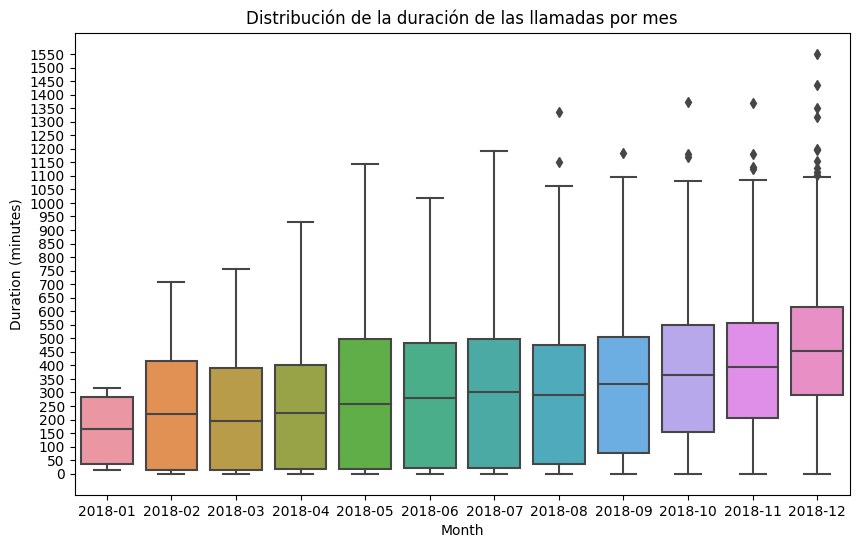

In [41]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
plt.figure(figsize=(10,6))
sns.boxplot(data=calls_min_mess_inter.sort_values(by='month'), x='month', y='duration')

plt.title('Distribución de la duración de las llamadas por mes')
plt.xlabel('Month')
plt.ylabel('Duration (minutes)')
plt.yticks(range(0, 1600, 50))
plt.show()

Es importante calcular el valor de las medianas de las cajas porque hay que recordar que representa el segundo cuartil, que quiere decir que el 50% de los datos de cada mes se encuentran por debajo de ese valor.  Entre mas ancha este la caja una mayor dispersión o variabilidad de los datos entre el Q1 y el Q3. Es decir, los datos están más extendidos y hay una mayor diferencia. Por el contrario cuando la caja esté más estrecha indica una menor dispersión de los datos. La mayoría de los valores están más concentrados alrededor de la mediana, sugiriendo que los datos son más similares entre sí.La mayoría tiene los bigotes superiores muy prolongados lo que sugiere valores significativamente altos. Incluso a partir de agosto se aprecia la presencia de valores atípicos, sobre todo en diciembre que existen bastantes de ellos en la distribución.

### Mensajes

,month,n of messages,duration,average,month str
0,2018-01,4,21.0,5.250000,Jan
1,2018-02,12,108.0,9.000000,Feb
2,2018-03,32,351.0,10.968750,Mar
3,2018-04,69,870.0,12.608696,Apr
4,2018-05,98,1772.0,18.081633,May
5,2018-06,137,2427.0,17.715328,Jun
6,2018-07,167,3165.0,18.952096,Jul
7,2018-08,213,4588.0,21.539906,Aug
8,2018-09,242,5866.0,24.239669,Sept
9,2018-10,283,7806.0,27.583039,Oct


,month,n of messages,duration,average,month str
0,2018-01,4,62.0,15.500000,Jan
1,2018-02,10,139.0,13.900000,Feb
2,2018-03,17,243.0,14.294118,Mar
3,2018-04,31,463.0,14.935484,Apr
4,2018-05,51,931.0,18.254902,May
5,2018-06,66,1374.0,20.818182,Jun
6,2018-07,84,1937.0,23.059524,Jul
7,2018-08,103,2732.0,26.524272,Aug
8,2018-09,119,3259.0,27.386555,Sept
9,2018-10,126,4179.0,33.166667,Oct


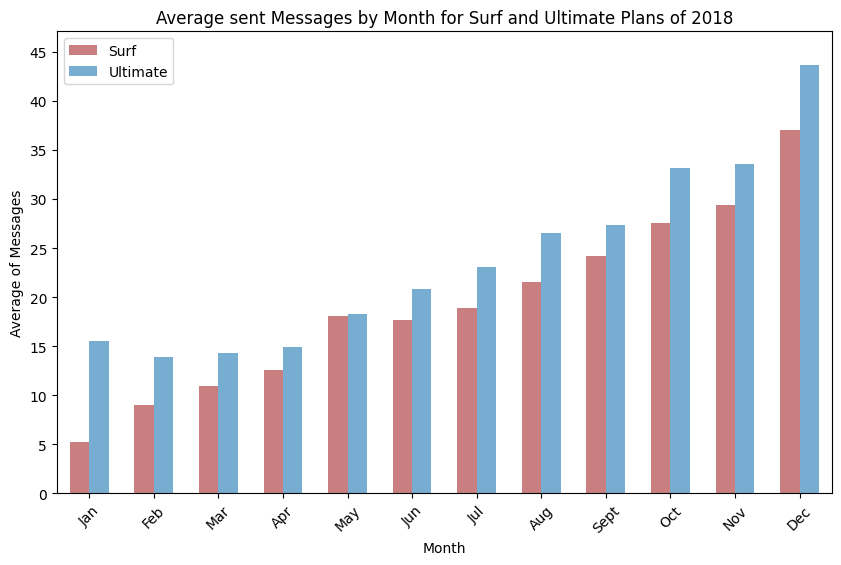

<Figure size 1000x600 with 0 Axes>

In [42]:
total_surf_meanmen_cou=total_surf.groupby('month')['messages'].count().reset_index()
total_surf_meanmen_sum=total_surf.groupby('month')['messages'].sum().reset_index()

total_surf_meanmen_tt=total_surf_meanmen_cou.merge(total_surf_meanmen_sum,on='month',how='left')
total_surf_meanmen_tt.columns=['month','n of messages','duration']
total_surf_meanmen_tt['average']=total_surf_meanmen_tt['duration']/total_surf_meanmen_tt['n of messages']
month_string_m=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
total_surf_meanmen_tt['month str']=month_string
display(total_surf_meanmen_tt)

print('\n')
###Ultimate

total_ult_meanmen_cou=total_ultimate.groupby('month')['messages'].count().reset_index()
total_ult_meanmen_sum=total_ultimate.groupby('month')['messages'].sum().reset_index()
# print(total_surf_mean_cou)
# print(total_surf_mean_sum)

total_ult_meanmen_tt=total_ult_meanmen_cou.merge(total_ult_meanmen_sum,on='month',how='left')
total_ult_meanmen_tt.columns=['month','n of messages','duration']
total_ult_meanmen_tt['average']=total_ult_meanmen_tt['duration']/total_ult_meanmen_tt['n of messages']
total_ult_meanmen_tt['month str']=month_string
display(total_ult_meanmen_tt)

# sdssdsdsd


# Posiciones para las barras
x = np.arange(len(total_surf_meanmen_tt['month str']))  # Posiciones de los meses
width = 0.3
plt.figure(figsize=(10,6))
# Gráfic urf
plt.bar(x - width/2, total_surf_meanmen_tt['average'], width=width, label='Surf', alpha=0.6, color='brown')

# Gráfico ltimate
plt.bar(x + width/2, total_ult_meanmen_tt['average'], width=width, label='Ultimate', alpha=0.6)

# Establecer las etiquetas del eje X con los nombres de los meses
plt.xticks(x, total_surf_meanmen_tt['month str'], rotation=45)  # Ajustar las etiquetas del eje X
plt.yticks(np.arange(0, max(total_surf_meanmen_tt['average']) + 25, 5))

plt.xlim(-0.5, len(total_surf_meanmen_tt['month str']) - 0.5) 
plt.ylim(0,total_surf_meanmen_tt['average'].max()+10)


plt.xlabel('Month')  
plt.ylabel('Average of Messages') 
plt.title('Average sent Messages by Month for Surf and Ultimate Plans of 2018') 
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

,month,messages
0,2018-01,21.0
1,2018-02,108.0
2,2018-03,351.0
3,2018-04,870.0
4,2018-05,1772.0
5,2018-06,2427.0
6,2018-07,3165.0
7,2018-08,4588.0
8,2018-09,5866.0
9,2018-10,7806.0


,month,messages
0,2018-01,62.0
1,2018-02,139.0
2,2018-03,243.0
3,2018-04,463.0
4,2018-05,931.0
5,2018-06,1374.0
6,2018-07,1937.0
7,2018-08,2732.0
8,2018-09,3259.0
9,2018-10,4179.0


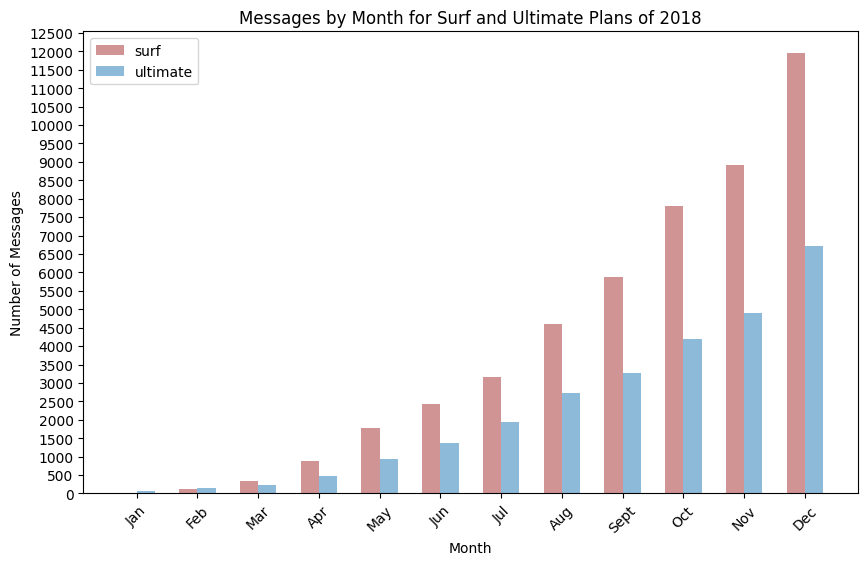

In [43]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
# display(total_surf)
mess_user_surf= total_surf.groupby('month')['messages'].sum().reset_index()
display(mess_user_surf)
mess_user_ultimate= total_ultimate.groupby('month')['messages'].sum().reset_index()
display(mess_user_ultimate)
plt.figure(figsize=(10,6))
width=0.3

plt.xticks(x, total_surf_mean_tt['month str'], rotation=45)
plt.bar(x-width/2,mess_user_surf['messages'],width=0.3,label='surf',alpha=0.5, color='brown')
plt.bar(x+width/2,mess_user_ultimate['messages'],width=0.3,label='ultimate',alpha=0.5)
plt.yticks(np.arange(0, 13000, 500))
# plt.xlim(-1,12,1)
plt.xlabel('Month')  
plt.ylabel('Number of Messages') 
plt.title('Messages by Month for Surf and Ultimate Plans of 2018') 
plt.legend()
plt.show()

Los usuarios con el plan surf tienden a mandar un mayor número de mensajes que aquellos que tienen el plan ultimate, con excepción de Enero y Febrero. Se puede predecir mediante estas gráficas de barras que en algunos meses puede haber muchos usuarios con recargos en este caso por sobrepasar el límite de mensajes, lo que beneficia a la compañía por los ingresos.

,month,messages
0,2018-01,21.0
1,2018-02,108.0
2,2018-03,351.0
3,2018-04,870.0
4,2018-05,1772.0
5,2018-06,2427.0
6,2018-07,3165.0
7,2018-08,4588.0
8,2018-09,5866.0
9,2018-10,7806.0


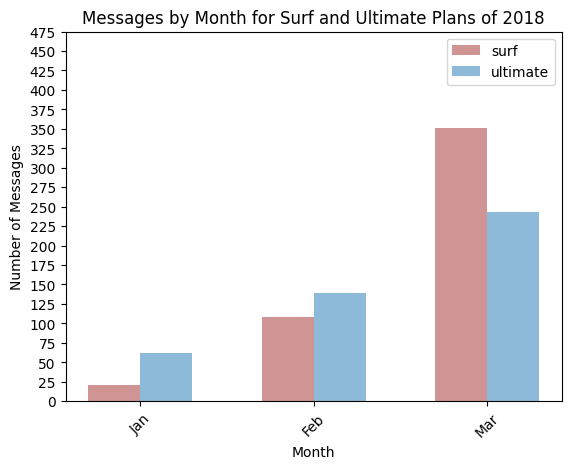

In [44]:
mess_user_3surf=total_surf.groupby('month')['messages'].sum().reset_index().iloc[:3]
mess_user_3ultimate=total_ultimate.groupby('month')['messages'].sum().reset_index().iloc[:3]
display(mess_user_surf)

x = np.arange(len(mess_user_3surf['month']))
# Etiquetas de los meses
# plt.xticks(x, mess_user_surf_first_3['month'], rotation=45)
plt.xticks(x, total_surf_mean_tt['month str'].iloc[:3], rotation=45)
plt.bar(x-width/2,mess_user_3surf['messages'],width=0.3,label='surf',alpha=0.5, color='brown')
plt.bar(x+width/2,mess_user_3ultimate['messages'],width=0.3,label='ultimate',alpha=0.5)
plt.yticks(np.arange(0, 500, 25))
# plt.xlim(-1,12,1)
plt.xlabel('Month')  
plt.ylabel('Number of Messages') 
plt.title('Messages by Month for Surf and Ultimate Plans of 2018') 
plt.legend()
plt.show()

Es la grafica anterior con zoom para ver los valores pequeños de la gráfica  anterior

### Internet

,month,n of gb,duration,average,month str
0,2018-01,4,10.0,2.500000,Jan
1,2018-02,12,110.0,9.166667,Feb
2,2018-03,32,312.0,9.750000,Mar
3,2018-04,69,611.0,8.855072,Apr
4,2018-05,98,1076.0,10.979592,May
5,2018-06,137,1487.0,10.854015,Jun
6,2018-07,167,2025.0,12.125749,Jul
7,2018-08,213,2698.0,12.666667,Aug
8,2018-09,242,3186.0,13.165289,Sept
9,2018-10,283,4059.0,14.342756,Oct


,month,n of messages,duration,average,month str
0,2018-01,4,62.0,15.500000,Jan
1,2018-02,10,139.0,13.900000,Feb
2,2018-03,17,243.0,14.294118,Mar
3,2018-04,31,463.0,14.935484,Apr
4,2018-05,51,931.0,18.254902,May
5,2018-06,66,1374.0,20.818182,Jun
6,2018-07,84,1937.0,23.059524,Jul
7,2018-08,103,2732.0,26.524272,Aug
8,2018-09,119,3259.0,27.386555,Sept
9,2018-10,126,4179.0,33.166667,Oct


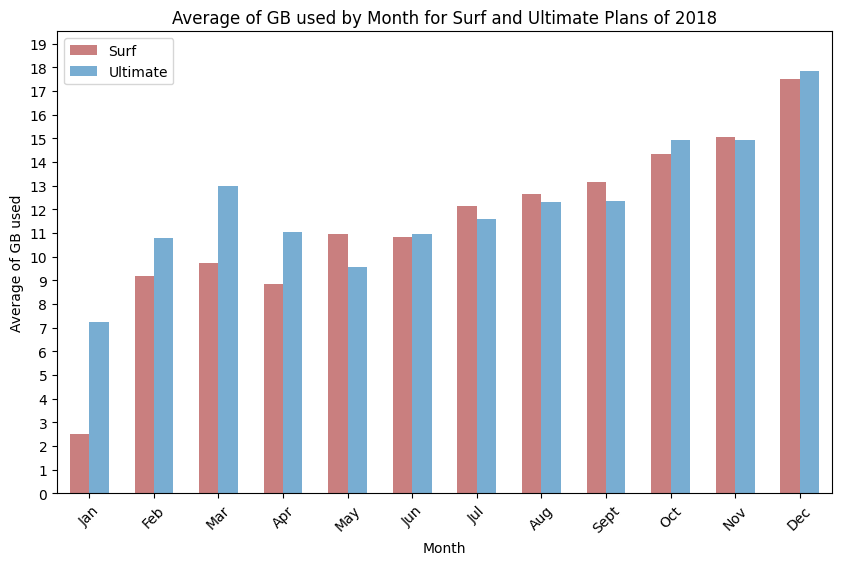

<Figure size 1000x600 with 0 Axes>

In [45]:
total_surf_meanin_cou=total_surf.groupby('month')['gb_used'].count().reset_index()
total_surf_meanin_sum=total_surf.groupby('month')['gb_used'].sum().reset_index()

total_surf_meanin_tt=total_surf_meanin_cou.merge(total_surf_meanin_sum,on='month',how='left')
total_surf_meanin_tt.columns=['month','n of gb','duration']
total_surf_meanin_tt['average']=total_surf_meanin_tt['duration']/total_surf_meanin_tt['n of gb']
month_string_m=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
total_surf_meanin_tt['month str']=month_string
display(total_surf_meanin_tt)

print('\n')
###Ultimate

total_ult_meanin_cou=total_ultimate.groupby('month')['gb_used'].count().reset_index()
total_ult_meanin_sum=total_ultimate.groupby('month')['gb_used'].sum().reset_index()
# print(total_surf_mean_cou)
# print(total_surf_mean_sum)

total_ult_meanin_tt=total_ult_meanin_cou.merge(total_ult_meanin_sum,on='month',how='left')
total_ult_meanin_tt.columns=['month','n of gb','duration']
total_ult_meanin_tt['average']=total_ult_meanin_tt['duration']/total_ult_meanin_tt['n of gb']
total_ult_meanin_tt['month str']=month_string
display(total_ult_meanmen_tt)

# sdssdsdsd


# Posiciones para las barras
x = np.arange(len(total_surf_meanin_tt['month str']))  # Posiciones de los meses
width = 0.3
plt.figure(figsize=(10,6))
# Gráfic urf
plt.bar(x - width/2, total_surf_meanin_tt['average'], width=width, label='Surf', alpha=0.6, color='brown')

# Gráfico ltimate
plt.bar(x + width/2, total_ult_meanin_tt['average'], width=width, label='Ultimate', alpha=0.6)

# Establecer las etiquetas del eje X con los nombres de los meses
plt.xticks(x, total_surf_meanin_tt['month str'], rotation=45)  # Ajustar las etiquetas del eje X
plt.yticks(np.arange(0, max(total_surf_meanin_tt['average']) + 25, 1))

plt.xlim(-0.5, len(total_surf_meanin_tt['month str']) - 0.5) 
plt.ylim(0,total_surf_meanin_tt['average'].max()+2)


plt.xlabel('Month')  
plt.ylabel('Average of GB used') 
plt.title('Average of GB used by Month for Surf and Ultimate Plans of 2018') 
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

,month,gb_used
0,2018-01,10.0
1,2018-02,110.0
2,2018-03,312.0
3,2018-04,611.0
4,2018-05,1076.0
5,2018-06,1487.0
6,2018-07,2025.0
7,2018-08,2698.0
8,2018-09,3186.0
9,2018-10,4059.0


,month,gb_used
0,2018-01,29.0
1,2018-02,108.0
2,2018-03,221.0
3,2018-04,343.0
4,2018-05,489.0
5,2018-06,724.0
6,2018-07,973.0
7,2018-08,1270.0
8,2018-09,1468.0
9,2018-10,1879.0


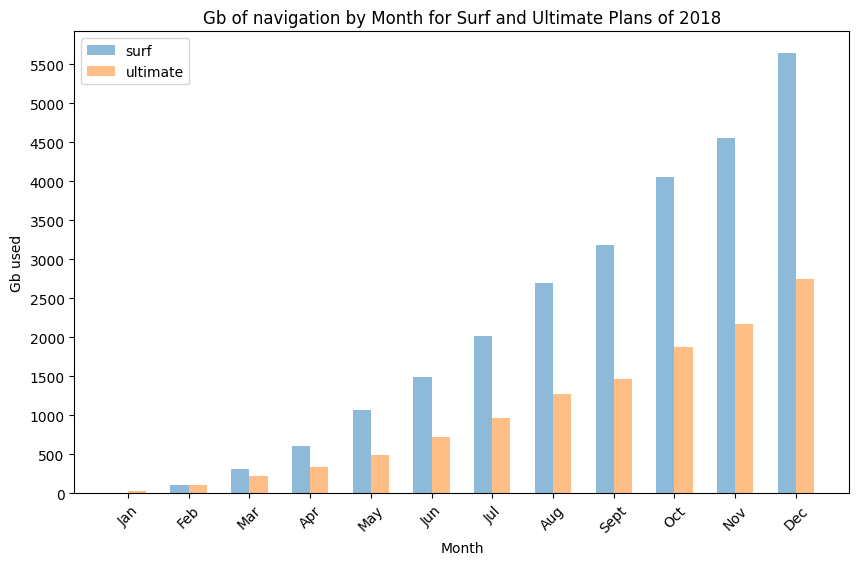

In [46]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

in_user_surf= total_surf.groupby('month')['gb_used'].sum().reset_index()
display(in_user_surf)
in_user_ultimate= total_ultimate.groupby('month')['gb_used'].sum().reset_index()
display(in_user_ultimate)
plt.figure(figsize=(10,6))
width=0.3
x2=np.arange(len(in_user_surf['month']))
plt.xticks(x2, total_surf_mean_tt['month str'], rotation=45)
plt.bar(x2-width/2,in_user_surf['gb_used'],width=0.3,label='surf',alpha=0.5)
plt.bar(x2+width/2,in_user_ultimate['gb_used'],width=0.3,label='ultimate',alpha=0.5)
plt.yticks(np.arange(0, 6000, 500))
# plt.xlim(-1,12,1)
plt.xlabel('Month')  
plt.ylabel('Gb used') 
plt.title('Gb of navigation by Month for Surf and Ultimate Plans of 2018') 
plt.legend()
plt.show()

En el plan surf hay un mayor consumo de gb de navegacion a excepción del mes de enero de una manera significativa frente al plan ultimate, y va creciendo conforme pasaron los meses.

,month,messages
0,2018-01,21.0
1,2018-02,108.0
2,2018-03,351.0
3,2018-04,870.0
4,2018-05,1772.0
5,2018-06,2427.0
6,2018-07,3165.0
7,2018-08,4588.0
8,2018-09,5866.0
9,2018-10,7806.0


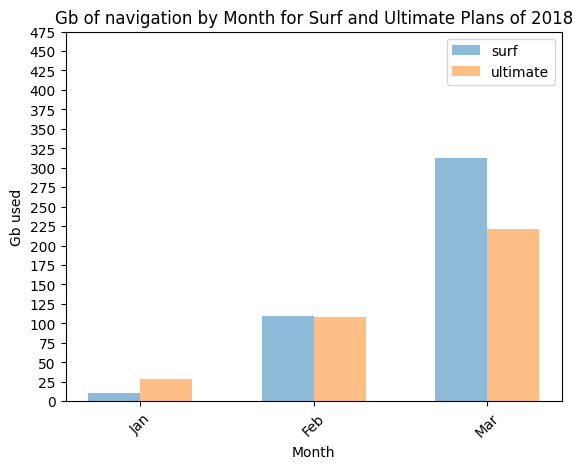

In [47]:
in_user_3surf=total_surf.groupby('month')['gb_used'].sum().reset_index().iloc[:3]
in_user_3ultimate=total_ultimate.groupby('month')['gb_used'].sum().reset_index().iloc[:3]
display(mess_user_surf)

x3 = np.arange(len(in_user_3surf['month']))
# Etiquetas de los meses
# plt.xticks(x, mess_user_surf_first_3['month'], rotation=45)
plt.xticks(x3, total_surf_mean_tt['month str'].iloc[:3], rotation=45)
plt.bar(x3-width/2,in_user_3surf['gb_used'],width=0.3,label='surf',alpha=0.5)
plt.bar(x3+width/2,in_user_3ultimate['gb_used'],width=0.3,label='ultimate',alpha=0.5)
plt.yticks(np.arange(0, 500, 25))
# plt.xlim(-1,12,1)
plt.xlabel('Month')  
plt.ylabel('Gb used') 
plt.title('Gb of navigation by Month for Surf and Ultimate Plans of 2018')
plt.legend()
plt.show()

El comportamiento si varía en función del plan, porque las personas que usan el plan surf tienen una tendencia consumir mas gb de navegación

## Ingreso

No hay ingresos de los usuarios del plan ultimate por recargso en minutos de llamada (duracion) y de mensajes. Con los usuarios del plan surf en el apartado de duración el 75% de los usuarios tienen cargos por duración de 0.09 dolares. Además de que el monto promedio de recargos es de 1.19 dolares. Existe una alta variabilidad debido a la desviación estandar, que es de 3.04 dolares. Esto indica que los cargos individuales pueden diferir significativamente del promedio. Finalmente, el cargo máximo fue de 29.28 dolares.

In [48]:
display(total_surf)
display(total_ultimate)
#Charge duration
display(total_surf['charge_duration'].describe())
display(total_ultimate['charge_duration'].describe())
print('\n')
#Charge messages
display(total_surf['charge_messages'].describe())
display(total_ultimate['charge_messages'].describe())
print('\n')

,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge
1,1001,2018-08,surf,27,182.0,30.0,7.0,0.0,0.00,0.0,20,20.00
2,1001,2018-09,surf,49,315.0,44.0,14.0,0.0,0.00,0.0,20,20.00
3,1001,2018-10,surf,65,393.0,53.0,22.0,0.0,0.09,70.0,20,90.09
4,1001,2018-11,surf,64,426.0,36.0,19.0,0.0,0.00,40.0,20,60.00
5,1001,2018-12,surf,56,412.0,44.0,19.0,0.0,0.00,40.0,20,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2788,1498,2018-12,surf,41,305.0,0.0,23.0,0.0,0.00,80.0,20,100.00
2789,1499,2018-09,surf,39,268.0,0.0,13.0,0.0,0.00,0.0,20,20.00
2790,1499,2018-10,surf,46,335.0,0.0,20.0,0.0,0.00,50.0,20,70.00
2791,1499,2018-11,surf,40,329.0,0.0,17.0,0.0,0.00,20.0,20,40.00


,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge
0,1000,2018-12,ultimate,16,124.0,11.0,2.0,0,0,0.0,70,70.0
19,1006,2018-11,ultimate,2,10.0,15.0,3.0,0,0,0.0,70,70.0
20,1006,2018-12,ultimate,9,59.0,139.0,32.0,0,0,14.0,70,84.0
26,1008,2018-10,ultimate,71,476.0,21.0,17.0,0,0,0.0,70,70.0
27,1008,2018-11,ultimate,63,446.0,37.0,24.0,0,0,0.0,70,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2773,1497,2018-07,ultimate,2,19.0,0.0,0.0,0,0,0.0,70,70.0
2774,1497,2018-08,ultimate,1,8.0,0.0,0.0,0,0,0.0,70,70.0
2775,1497,2018-09,ultimate,1,0.0,0.0,0.0,0,0,0.0,70,70.0
2776,1497,2018-11,ultimate,4,7.0,0.0,0.0,0,0,0.0,70,70.0


count    1882.000000
mean        1.506424
std         3.472689
min         0.000000
25%         0.000000
50%         0.000000
75%         0.952500
max        31.530000
Name: charge_duration, dtype: float64

count    911.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: charge_duration, dtype: float64

count    1882.000000
mean        0.172396
std         0.538318
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         6.480000
Name: charge_messages, dtype: float64

count    911.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: charge_messages, dtype: float64

El promedio de recargos por mensaje es 0.17 dolares Existe una variabilidad moderada en los cargos por mensajes, con una desviación estándar de 0.54 dolares.. Esto indica que los cargos individuales pueden diferir significativamente del promedio. Finalmente, el cargo máximo fue de 6.48 dolares. 

En los cargos por uso de gb de navegació de internet cambió el comportamiento para los usuarios del plan ultimate debido a que si presentaron recargos. 
En el plan surf la media fue de 33.85 dolares y máximo monto fue de 560 dolares. El 75% de los usuarios generan 50 dolares de ingreso por gb de navegación, aunque hay una alta variabilidad en los cargos por internet, lo que sugiere que algunos usuarios generan cargos significativamente altos mientras que otros no incurren en cargos adicionales según la desviación estandar de 52.03 dolares.
En el plan ultimate la media es muy baja con 2.09 dolares. Se aprecia que hay una baja variabilidad según la desviación estandar de 11.24 lo que quiere decir que la mayoría de usuarios incurren en gastos similares.El monto máximo fue de 119 dolares 

In [49]:
#Charge internet
display(total_surf['charge_internet'].describe())
display(total_ultimate['charge_internet'].describe())
print('\n')
#Total Charge
display(total_surf['total_charge'].describe())
display(total_ultimate['total_charge'].describe())
print('\n')

count    1882.000000
mean       31.439957
std        49.956907
min         0.000000
25%         0.000000
50%         0.000000
75%        50.000000
max       550.000000
Name: charge_internet, dtype: float64

count    911.000000
mean       1.798024
std       10.178130
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      112.000000
Name: charge_internet, dtype: float64

count    1882.000000
mean       53.118778
std        51.058956
min        20.000000
25%        20.000000
50%        27.260000
75%        70.682500
max       587.520000
Name: total_charge, dtype: float64

count    911.000000
mean      71.798024
std       10.178130
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: total_charge, dtype: float64

En los cargos totales, que es la suma de todos los cargos con la tarifa fija de cada plan, se observa que en el plan surf la media es de 52.97 dolares con una desviación estandar de 52.97 dolares que sugiere una alta variabilidad en el recibo de gastos para cada usuario. El mínimo es el cargo mensual por mes de 20 dolares y el 75% de los usuarios alcazan un ingreso para la compañía de 79.56 dolares lo cual es un monto bastante alto. Teniendo un valor máximo de 595.9 dolares. 
Volviendo al plan ultimate, la media fue de 72.09 dolares, un poco por encima del valor mínimo que es igual al valor del plan por mes. El valor máximo fue de 189 dolares. La desviación estandar nos indica que hay poca variabilidad entre los ingresos de los usuarios de este plan. A pesar de eso la media es mucho mayor que la del plan surf.

## Prueba las hipótesis estadísticas

La hipotesis nula es que los ingresos promedio entre los usuarios de los planes surf y ultimate son iguales.
La hipotesis alternativa es que los ingresos promedio entre los usuarios de los planes surf y ultimate son diferentes.
Se analizó la hipotesis con una prueba de t e muestras independientes dado que las varianzas no son iguales en los dos grupos, y se concluyó que se rechaza la hipotesis nula debido a que los ingresos medios entre los dos planes no son iguales. El valor p obtenido fue 2.03e-38, lo cual es significativamente menor que el nivel de significancia establecido de α = 0.05. Existen diferencias estadísticamente significativas en los ingresos promedio entre los usuarios de los planes Surf y Ultimate. Por lo tanto, podemos concluir que los ingresos generados por estos dos planes no son iguales, y que las diferencias observadas entre ellos no son atribuibles al azar.

In [50]:
# Prueba las hipótesis
display(total_surf['total_charge'].var())
display(total_ultimate['total_charge'].var())
alpha = 0.05

results=st.ttest_ind(total_surf['total_charge'],total_ultimate['total_charge'],equal_var=False)

print('valor p:',results.pvalue)# tu código: imprime el valor p obtenido)

if (results.pvalue<alpha):# su código: compara los valores p obtenidos con el nivel de significación estadística):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")
    

2607.0169452361297

103.59432576205354

valor p: 5.271245822616322e-50
Rechazamos la hipótesis nula


La hipotesis nula es que el ingreso promedio de los usuarios de NY-NJ es igual al ingreso promedio de los usuarios de otras regiones.
La hipotesis alternativa es que el ingreso promedio de los usuarios de NY-NJ es diferente al ingreso promedio de los usuarios de otras regiones.
Los resultados indican que el valor p obtenido es 0.8064, lo que es mucho mayor que 0.05. Como resultado, no se puede rechazar la hipótesis nula, lo que implica que los ingresos promedio de los usuarios de NY-NJ son iguales de los de otras regiones. Se analizó la hipotesis con una prueba de t de muestras independientes dado que las varianzas no son iguales en los dos grupos y son de dos regiones diferentes.

In [51]:
# Prueba las hipótesis
#users_uni=users_df['state'].unique()
#print(users_uni)
# Filtrar los usuarios del área NY-NJ-PA MSA
users_NY_NJ = users_df[users_df['state'] == ' NY-NJ-PA MSA']
users_NY_NJ = users_NY_NJ.groupby(['user_id','state'])['churn_date'].count()
# display(users_NY_NJ)
# Filtrar los usuarios de otras áreas
users_rest = users_df[users_df['state'] != ' NY-NJ-PA MSA']
users_rest = users_rest.groupby(['user_id','state'])['churn_date'].count()
# display(users_rest)
#Total
total_plans=pd.concat([total_surf,total_ultimate],ignore_index=True)
display('Tabla de ingresos de los dos planes',total_plans[total_plans['user_id']==1001])
display('Tabla de ingresos de los dos planes',total_plans)
##Sumar las cantidades y agrupar por id para un nuevo dataframe y hacer un merge
total_plans_grouped=total_plans.groupby(['user_id','plan']).sum()
display(total_plans_grouped)

'Tabla de ingresos de los dos planes'

,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge
0,1001,2018-08,surf,27,182.0,30.0,7.0,0.0,0.00,0.0,20,20.00
1,1001,2018-09,surf,49,315.0,44.0,14.0,0.0,0.00,0.0,20,20.00
2,1001,2018-10,surf,65,393.0,53.0,22.0,0.0,0.09,70.0,20,90.09
3,1001,2018-11,surf,64,426.0,36.0,19.0,0.0,0.00,40.0,20,60.00
4,1001,2018-12,surf,56,412.0,44.0,19.0,0.0,0.00,40.0,20,60.00


'Tabla de ingresos de los dos planes'

,user_id,month,plan,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge
0,1001,2018-08,surf,27,182.0,30.0,7.0,0.0,0.00,0.0,20,20.00
1,1001,2018-09,surf,49,315.0,44.0,14.0,0.0,0.00,0.0,20,20.00
2,1001,2018-10,surf,65,393.0,53.0,22.0,0.0,0.09,70.0,20,90.09
3,1001,2018-11,surf,64,426.0,36.0,19.0,0.0,0.00,40.0,20,60.00
4,1001,2018-12,surf,56,412.0,44.0,19.0,0.0,0.00,40.0,20,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2788,1497,2018-07,ultimate,2,19.0,0.0,0.0,0.0,0.00,0.0,70,70.00
2789,1497,2018-08,ultimate,1,8.0,0.0,0.0,0.0,0.00,0.0,70,70.00
2790,1497,2018-09,ultimate,1,0.0,0.0,0.0,0.0,0.00,0.0,70,70.00
2791,1497,2018-11,ultimate,4,7.0,0.0,0.0,0.0,0.00,0.0,70,70.00


,,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge
user_id,plan,,,,,,,,,
1000,ultimate,16,124.0,11.0,2.0,0.00,0.00,0.0,70,70.00
1001,surf,261,1728.0,207.0,81.0,0.00,0.09,150.0,100,250.09
1002,surf,113,829.0,88.0,41.0,0.00,0.00,40.0,60,100.00
1003,surf,149,1104.0,50.0,27.0,18.12,0.00,120.0,20,158.12
1004,surf,370,2772.0,177.0,157.0,0.00,0.00,450.0,160,610.00
...,...,...,...,...,...,...,...,...,...,...
1495,surf,253,1765.0,0.0,99.0,3.12,0.00,390.0,100,493.12
1496,surf,195,1455.0,65.0,66.0,0.00,0.00,40.0,100,140.00
1497,ultimate,54,300.0,50.0,11.0,0.00,0.00,0.0,560,560.00


In [52]:
total_plans_zone= total_plans_grouped.merge(users_df,on='user_id',how='left')
# display(total_plans_zone)
total_plans_zone_d=total_plans_zone[['user_id','state','city']]
# display(total_plans_zone_d)

total_plans_final=total_plans_grouped.merge(total_plans_zone_d,on='user_id',how='left')
display(total_plans_final)

total_final_NY_NJ= total_plans_final[ total_plans_final['state']==' NY-NJ-PA MSA']
total_final_rest= total_plans_final[ total_plans_final['state']!=' NY-NJ-PA MSA']

# display(total_final_NY_NJ)
# display(total_final_rest)

,user_id,calls,duration,messages,gb_used,charge_duration,charge_messages,charge_internet,monthly_charge,total_charge,state,city
0,1000,16,124.0,11.0,2.0,0.00,0.00,0.0,70,70.00,GA MSA,Atlanta-Sandy Springs-Roswell
1,1001,261,1728.0,207.0,81.0,0.00,0.09,150.0,100,250.09,WA MSA,Seattle-Tacoma-Bellevue
2,1002,113,829.0,88.0,41.0,0.00,0.00,40.0,60,100.00,NV MSA,Las Vegas-Henderson-Paradise
3,1003,149,1104.0,50.0,27.0,18.12,0.00,120.0,20,158.12,OK MSA,Tulsa
4,1004,370,2772.0,177.0,157.0,0.00,0.00,450.0,160,610.00,WA MSA,Seattle-Tacoma-Bellevue
...,...,...,...,...,...,...,...,...,...,...,...,...
495,1495,253,1765.0,0.0,99.0,3.12,0.00,390.0,100,493.12,NY-NJ-PA MSA,New York-Newark-Jersey City
496,1496,195,1455.0,65.0,66.0,0.00,0.00,40.0,100,140.00,LA MSA,New Orleans-Metairie
497,1497,54,300.0,50.0,11.0,0.00,0.00,0.0,560,560.00,CA MSA,Los Angeles-Long Beach-Anaheim
498,1498,451,3211.0,0.0,228.0,0.00,0.00,630.0,220,850.00,NY-NJ-PA MSA,New York-Newark-Jersey City


In [53]:
# Prueba las hipótesis
display(total_final_NY_NJ['total_charge'].var())
display(total_final_rest['total_charge'].var())
alpha = 0.05

results=st.ttest_ind(total_final_NY_NJ['total_charge'],total_final_rest['total_charge'],equal_var=False)

print('valor p:',results.pvalue)# tu código: imprime el valor p obtenido)

if (results.pvalue<alpha):# su código: compara los valores p obtenidos con el nivel de significación estadística):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

52824.08275031646

73907.64317421525

valor p: 0.7072410231188988
No podemos rechazar la hipótesis nula


## Conclusión general


1. Acondicionamiento de los datos: Es importante observar los valores que se emplean desde un inicio en los dataframes crudos para hacer que sean más fáciles de digerir para cualquier persona, es decir, hacer la conversión de valores como en el caso de los gb, hacer columnas con nombres adecuados, tener las tablas a la mano para saber que valores se van a agrupar o se van a unir entre ellos para obtener una unica tabla con valores de dos tablas. Asegurarse de que los valores de fechas esten en el formato de fechas y no de strings, porque de esta manera no se puede interacturar igual, y a pesar de que se puede manipularlos resulta en más trabajo. Además de conocer si en las columnas no hay valores ausentes que puedan afectar las mediciones de todo el conjunto de datos existentes en ellas. Básicamente tener una rutina donde se puedan ir descartando estos pequeños detalles y poder tener al finalizarla datos limpios y listos para poder ser procesados.


2. Estudiar las condiciones para el procesamiento. En terminos de la compañía me refiero a la forma en la que las tarifas son cobradas dependiendo de los excedentes en las variables del plan. Si bien en la tarifa surf hay mas variabilidad de datos, se deben de implementar líneas de código que nos permitan asegurarnos de que dichos ingresos para la compañía no se pasan por alto y son considerados en todo momento. Implementados en las variables de mensajes, de gb de navegación en internet y duración de las llamadas. Considerando que las condiciones de cobro son por decimales que excedan del limite que al final se terminaran cobrando por enteros, lo cual es muy fundamental para no romper con la política de la empresa.


3. Visualización de los datos. El procesamiento de los datos pasa por medios gráficos que permitan desglozar lo que pueden ser hallazgos en los datos. Con ello es sencillo analizar los  valores máximos y los mínimos de todas las gráficas, pero sobre todo comparar los grupos a analizar; ver cual tiene mayores números que el otro, como van evolucionando los datos dependiendo de la línea del tiempo durante la cual se quisieron analizar, la tendencia de los usuarios pertenecientes a los dos planes y para justificar el porque se dice que una plan consume más recursos que el otro. Con los histogramas se puede ver la frecuencia de los valores de los datos y con las graficas de caja se observa la disttribución de los mismos y  donde se encuentran sus valores medios, resultan ser valores que se muestran en todo momento y son faciles de deducir si se conoce bien la representación de dicho gráfico.


4. Interpretación de la estadística. Posteriormente son analizadas las columnas con los cargos por cada plan, donde en el plan ultimate al ser un plan con un límite alto en las 3 variables consideradas para este proyecto, por lo tanto no vemos recargos en mensajes y en duración de llamadas, si no hasta en internet donde existen valores altos. A pesar de esto vemos que al final es el plan que da mayor ingreso a la compañía porque su tarifa de 70 dolares para un número de usuarios que de hecho es menor a los del plan surf da una media por encima de ese valor, dando como resultado un plan que genera más ingresos promedio aseguraando estabilidad financiera. Mientras que para los usuarios del plan surf aumenta la media con respecto a la tarifa base aunque existe una mayor variabilidad en los datos porque sus límites de las 3 variables son muy bajos para el consumo de los usuarios en general, por lo que requiere de una mayor gestión de ingresos por recargos pero aumenta la media con respecto a la tarifa base resultando en un plan con potencial para ingresos adicionales.
